### Olist cote vendeurs

Les clients d'olist sont les vendeurs. Nous allons faire une segmentation des vendeurs, utilisable par olist, et relier cette segmentation a celle des clients des vendeurs

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patheffects as PathEffects
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter
import seaborn as sns

import numpy as np
import pickle

from collections import OrderedDict
from functools import partial
from time import time

from sklearn.preprocessing import MinMaxScaler
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,OPTICS, cluster_optics_dbscan,SpectralClustering
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score,\
adjusted_rand_score,homogeneity_score, adjusted_mutual_info_score, fowlkes_mallows_score
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer,InterclusterDistance

import fonctions_OCR as fc

In [11]:
df = pd.read_csv("C:/Users/leila/seller.csv",index_col=0)

Nous avons vu que nb_customers, nb_orders et total_items sont fortement correles, nous n'allons garder que la colonne nb_customers

In [12]:
dfv = df.drop(['nb_orders','Total_items'],axis=1)

In [13]:
dfv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2970 entries, 0015a82c2db000af6aaaf3ae2ecb0532 to ffff564a4f9085cd26170f4732393726
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nb_customers                 2970 non-null   int64  
 1   turnover                     2970 non-null   float64
 2   mean_delivery_nb_days        2970 non-null   float64
 3   mean_review_score            2970 non-null   float64
 4   mean_freight                 2970 non-null   float64
 5   baby_toys                    2970 non-null   float64
 6   books_dvd_media_stationery   2970 non-null   float64
 7   fashion_clothes_accessories  2970 non-null   float64
 8   furnitures                   2970 non-null   float64
 9   gifts_flowers                2970 non-null   float64
 10  health_beauty                2970 non-null   float64
 11  home                         2970 non-null   float64
 12  others                

Mise a l'echelle

In [14]:
minmax = MinMaxScaler()
X = dfv.copy()
X_scaled = minmax.fit_transform(X)

**PCA**

Commencons par une analyse par composante principale pour tenter une diminution des dimensions

In [15]:
pca = PCA()
pca_result = pca.fit(X_scaled)

Eboulis des valeurs propres

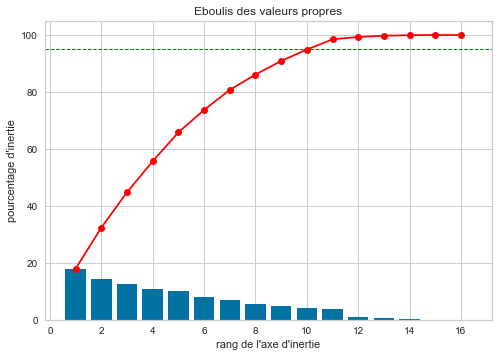

In [16]:
fc.display_scree_plot(pca)

Avec 11 composantes 98 % de variance expliquee

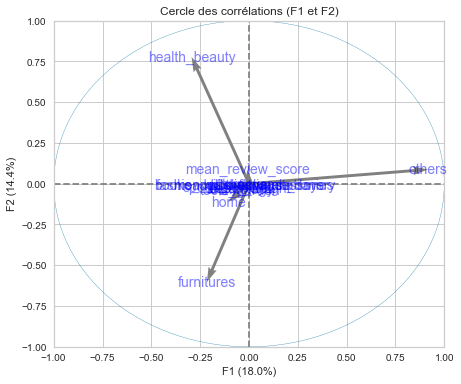

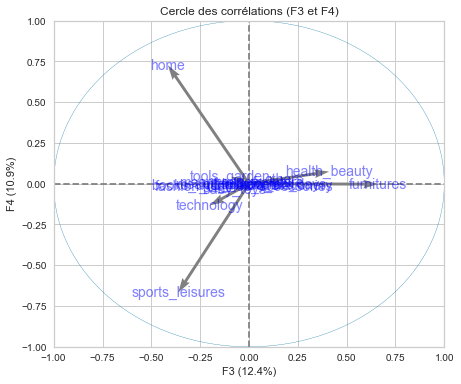

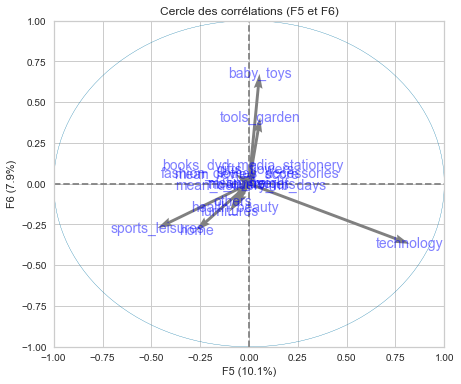

In [17]:
# representation des variables suivant les axes
n_comp = 11
pcs = pca.components_
features = X.columns
fc.display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

On constate que les categories sont dominantes, on va supprimer les categories pour avoir des composantes plus significatives

In [18]:
list_cat = ['health_beauty','sports_leisures','baby_toys','home','furnitures','tools_garden','technology',
          'fashion_clothes_accessories','gifts_flowers','books_dvd_media_stationery','others']
X_out_cat = X.drop(list_cat,axis=1)

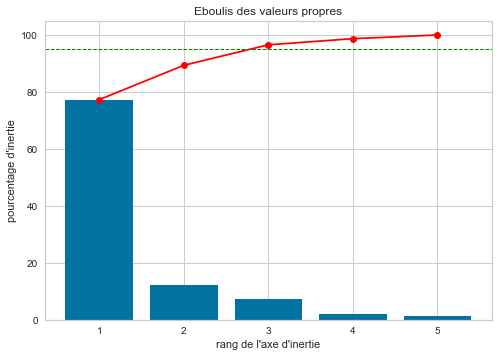

In [19]:
#mise a l'echelle
X_scaled = minmax.fit_transform(X_out_cat)

# pca sur le X reduit  et eboulis des valeurs propres
pca_result = pca.fit(X_scaled)
fc.display_scree_plot(pca)

Avec 4 composantes, 99 % de la variance est expliquee

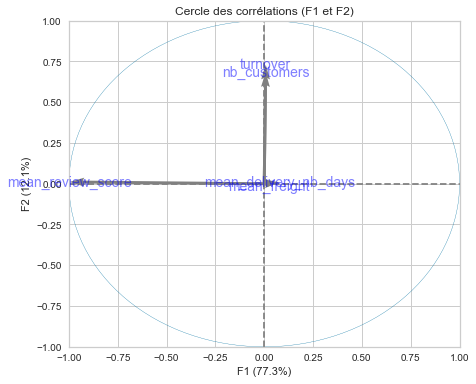

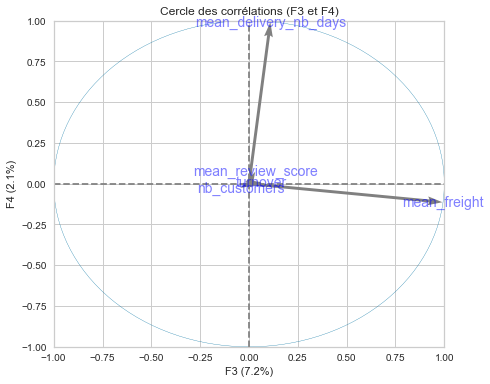

In [20]:
# projection des features suivant les axes
n_comp = 4
pcs = pca.components_
features = X_out_cat.columns
fc.display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

Les variables qui contribuent le plus a chaque axe sont clairement identifiables :

- pour  𝐹1  : l'avis du client
- pour  𝐹2  : nombre de clients et chiffre d'affaire
- pour  𝐹3  : prix moyen du fret
- pour  𝐹4  : nombre moyen de jours pour une livraison

In [21]:
# calcul des projetes
pca_result = pca.transform(X_scaled)[:,:4]

In [22]:
# dataframe des resultats de la projection sur les 5 composantes 
df_pca = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

for k in range(4) :
    df_pca['pca'+str(k+1)] = pca_result[:,k]


<AxesSubplot:title={'center':'Plan factoriel pour les 2 premières composantes de PCA'}, xlabel='Composante 1', ylabel='Composante 2'>

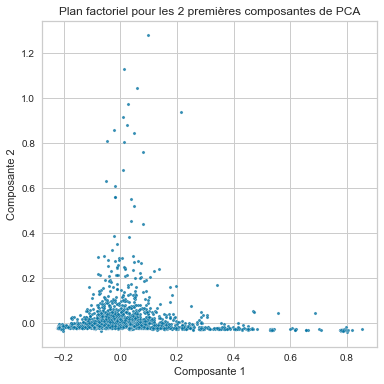

In [23]:
# representation des observations sur le premier plan factoriel
plt.figure(figsize=(6,6))

plt.title('Plan factoriel pour les 2 premières composantes de PCA')
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')

sns.scatterplot(x = df_pca['pca1'],y = df_pca['pca2'], alpha=0.8, s=10)

Representation des donnees dans differentes varietes de dimension 2

LLE: 1.8 sec
LTSA: 2 sec
Modified LLE: 2.1 sec
Isomap: 2.9 sec
MDS: 28 sec
SE: 1.5 sec
t-SNE: 26 sec


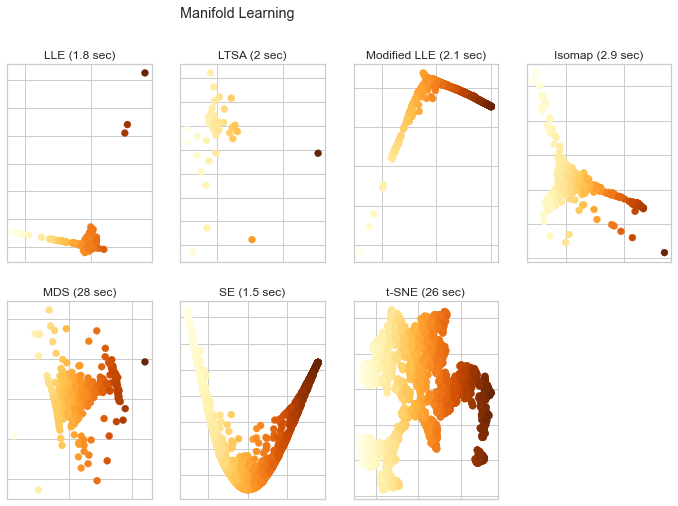

In [24]:
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning ")


# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding, eigen_solver='dense')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap()
methods['MDS'] = manifold.MDS(max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding()
methods['t-SNE'] = manifold.TSNE(init='pca', random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X_scaled)
    color=Y[:, 0]
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.YlOrBr)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

In [25]:
def representer(data,mesure):
    '''Permet de visuliser les differentes mesures utilisees'''
    model=mesure
    model.fit(data)
    model.show()

In [26]:
# mise a l'echelle des projetes
pca_result_scaled = minmax.fit_transform(pca_result)

Recherche du nombre de clusters par la methode du coude

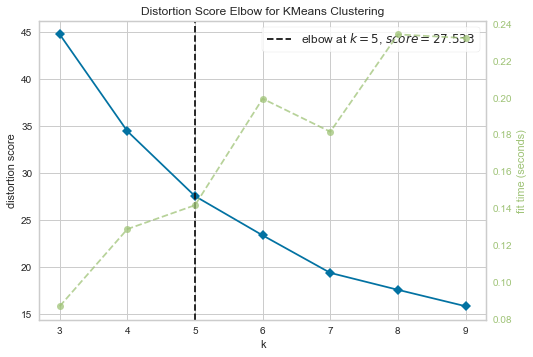

In [27]:
representer(pca_result_scaled,KElbowVisualizer(KMeans(),k=(3,10)))
 

Le coude n'est pas franc, le nombre de voisinages preconise par cette methode est 5. Nous allons etudier differentes mesures pour tenter de determiner au mieux le nombre de clusters

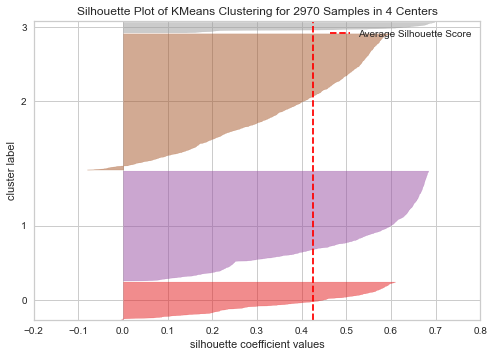

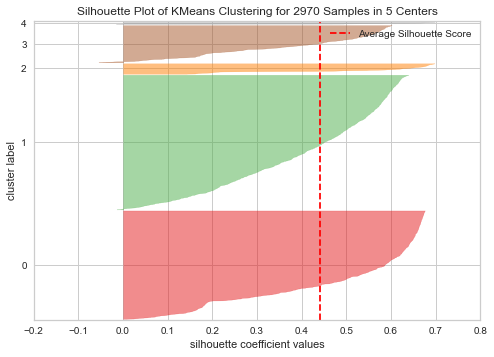

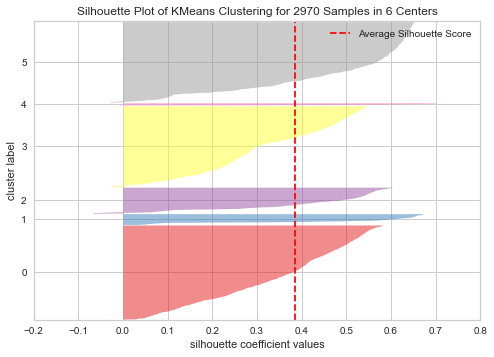

In [28]:
# etude des silhouettes 
for k in [4,5,6]:
    representer(pca_result_scaled,SilhouetteVisualizer(KMeans(k)))

D'apres les visulisations des silhouettes, le nombre de 5 clusters est valide. Les clusters ne seront pas tres equilibres

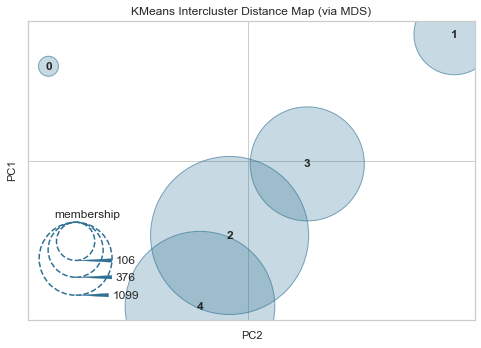

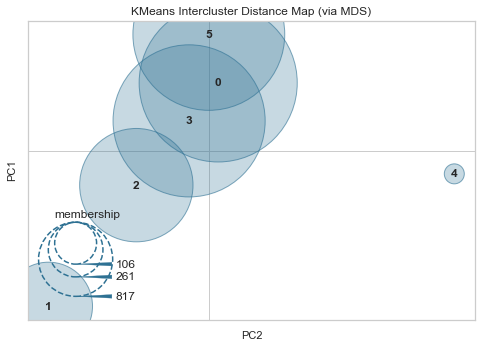

In [29]:
# etude des distance inter-clusters
for k in [5,6] :
    representer(pca_result_scaled,InterclusterDistance(KMeans(k)))

Beaucoup trop de chevauchements pour 6 clusters, on va donc utiliser 5 clusters

In [30]:
# mise en place de 5 clusters par l'algorithme de KMeans
kmeans5 = KMeans(5)
kmeans5.fit(pca_result_scaled)
kmeans5_labels = kmeans5.labels_
df_pca['kmeans_label'] = kmeans5_labels

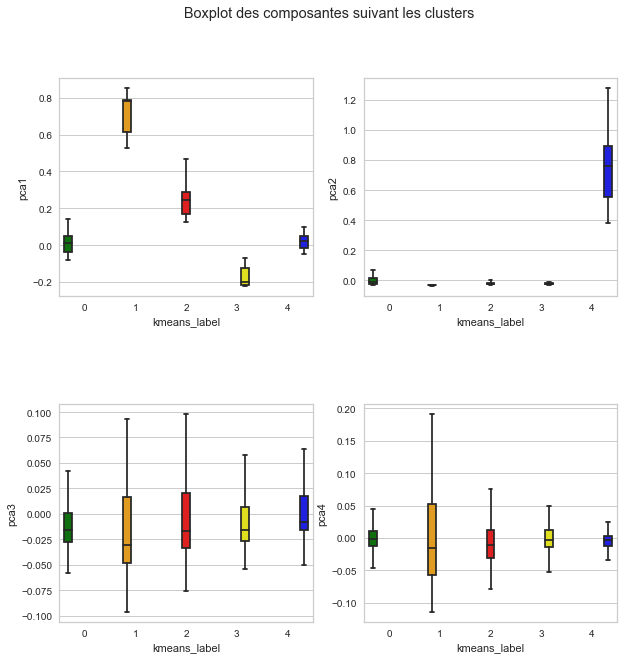

In [31]:
#representation des composantes suivant les clusters
fig = plt.figure(figsize = (10, 10))
plt.gcf().subplots_adjust(hspace = 0.5, wspace = 0.2)
plt.suptitle('Boxplot des composantes suivant les clusters')

for k in range(4) :
    ax = fig.add_subplot(2, 2, 1 + k )
    ax = sns.boxplot(data = df_pca, x = 'kmeans_label', y = 'pca'+str(k+1), hue = 'kmeans_label',
                palette = {0:'green', 1:'orange', 2:'red', 3:'yellow', 4:'blue'}, showfliers=False)
    plt.gca().legend().set_visible(False)
plt.show()

In [32]:
# repartition des vendeurs suivant les clusteurs
df_pca['kmeans_label'].value_counts().sort_values()

4      23
1     106
2     377
3    1099
0    1365
Name: kmeans_label, dtype: int64

**Stabilite des clusters**

L'algorithme du K-Means testé ici est initialisé avec la méthode K-Means++, ce qui réduit déjà les effets aléatoires de l'initialisation des centroïdes. On va tester la stabilité à l'initialisation en entrainant plusieurs fois le modèle sans fixer le RandomState.

Pour les labels initiaux, on conserve les clusters que l'on vient de calculer puis les comparer grâce à l'indice de Rand ajusté (ARI) pour chacune des itérations.

In [33]:
labels = kmeans5_labels
X_test=pca_result_scaled

In [34]:
def stability_init(model, name, data, labels) :
    
    estimator = model.fit(data)
    results = [name]
    
    # test differents metrics 
    clustering_metrics = [homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score,
                         fowlkes_mallows_score]
    results += [m(labels, estimator.labels_) for m in clustering_metrics]
    
    # print the results
    formatter_result = ("{:9s}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))


print("Scores de stabilité à l'initialisation")
print('Iteration\tHomo\tARI\tAMI\tFMI')
for k in range(7):
    imodel = KMeans(n_clusters=5, n_init=1, init="k-means++")
    stability_init(model = imodel, name = "Test "+str(k), data = X_test, labels = labels)


Scores de stabilité à l'initialisation
Iteration	Homo	ARI	AMI	FMI
Test 0   	0.927	0.941	0.916	0.962
Test 1   	0.704	0.488	0.631	0.654
Test 2   	0.847	0.854	0.816	0.906
Test 3   	0.904	0.918	0.890	0.948
Test 4   	0.996	0.999	0.997	0.999
Test 5   	0.699	0.479	0.627	0.648
Test 6   	0.926	0.940	0.914	0.962


La stabilite des clusters est faible, on va regarder si en utilisant une partition spectral on arrive a une meilleure stabilite.  
Recherche des valeurs de gamma 

In [35]:
for gamma in [0.7,1,2,3,4] :
    spectral_rbf1 = SpectralClustering(n_clusters=5, eigen_solver='arpack', affinity='rbf', gamma=gamma).fit(pca_result_scaled)
    spectral_rbf1_labels=spectral_rbf1.labels_
    print(gamma)
    print('silhouette_score : ',silhouette_score(pca_result_scaled,spectral_rbf1_labels))
    print('calinski_harabasz_score : ',calinski_harabasz_score(pca_result_scaled,spectral_rbf1_labels))
    print('davies_bouldin_score : ',davies_bouldin_score(pca_result_scaled,spectral_rbf1_labels))

0.7
silhouette_score :  0.41807895819525454
calinski_harabasz_score :  1556.1408976483115
davies_bouldin_score :  0.8041384263251654
1
silhouette_score :  0.41969262098200244
calinski_harabasz_score :  1567.321605360281
davies_bouldin_score :  0.7977049324137375
2
silhouette_score :  0.42874483886560866
calinski_harabasz_score :  1596.6607931378612
davies_bouldin_score :  0.7496135869596348
3
silhouette_score :  0.42945919592582404
calinski_harabasz_score :  1519.686211586948
davies_bouldin_score :  0.7210551687983513
4
silhouette_score :  0.6837268190148265
calinski_harabasz_score :  455.3695159925234
davies_bouldin_score :  0.6914975299528925


On doit, a priori, choisir entre gamma = 2 et gamma = 4, on va donc regarder la stabilite a l'initialisation

In [36]:
spectral_rbf2 = SpectralClustering(n_clusters=5, eigen_solver='arpack', affinity='rbf', gamma=2).fit(pca_result_scaled)
spectral_rbf2_labels = spectral_rbf2.labels_


In [37]:
# pour gamma = 2
labels=spectral_rbf2_labels
print("Scores de stabilité à l'initialisation")
print('Iteration\tHomo\tARI\tAMI\tFMI')
for k in range(7):
    imodel = SpectralClustering(n_clusters=5, eigen_solver='arpack', affinity='rbf', gamma=2)
    stability_init(model = imodel, name = "Test "+str(k), data = X_test, labels = labels)

Scores de stabilité à l'initialisation
Iteration	Homo	ARI	AMI	FMI
Test 0   	0.980	0.990	0.981	0.995
Test 1   	0.990	0.995	0.989	0.997
Test 2   	0.975	0.988	0.976	0.994
Test 3   	0.959	0.974	0.960	0.986
Test 4   	0.968	0.983	0.969	0.991
Test 5   	1.000	1.000	1.000	1.000
Test 6   	0.976	0.988	0.977	0.993


In [38]:
# pour gamma = 4
spectral_rbf4 = SpectralClustering(n_clusters=5, eigen_solver='arpack',
                                   affinity='rbf', gamma=4).fit(pca_result_scaled)
spectral_rbf4_labels = spectral_rbf4.labels_
labels=spectral_rbf4_labels
print("Scores de stabilité à l'initialisation")
print('Iteration\tHomo\tARI\tAMI\tFMI')
for k in range(7):
    imodel = SpectralClustering(n_clusters=5, eigen_solver='arpack', affinity='rbf', gamma=2)
    stability_init(model = imodel, name = "Test "+str(k), data = X_test, labels = labels)

Scores de stabilité à l'initialisation
Iteration	Homo	ARI	AMI	FMI
Test 0   	0.902	0.106	0.282	0.699
Test 1   	0.907	0.106	0.284	0.700
Test 2   	0.902	0.106	0.282	0.699
Test 3   	0.907	0.106	0.284	0.700
Test 4   	0.902	0.106	0.282	0.699
Test 5   	0.902	0.106	0.282	0.699
Test 6   	0.902	0.106	0.282	0.700


On a une bien meilleure stabilite avec gamma = 2. On va donc utiliser une partition spectral  avec gamma = 2

In [39]:
df_pca['spectral_rbf_labels'] = spectral_rbf2_labels

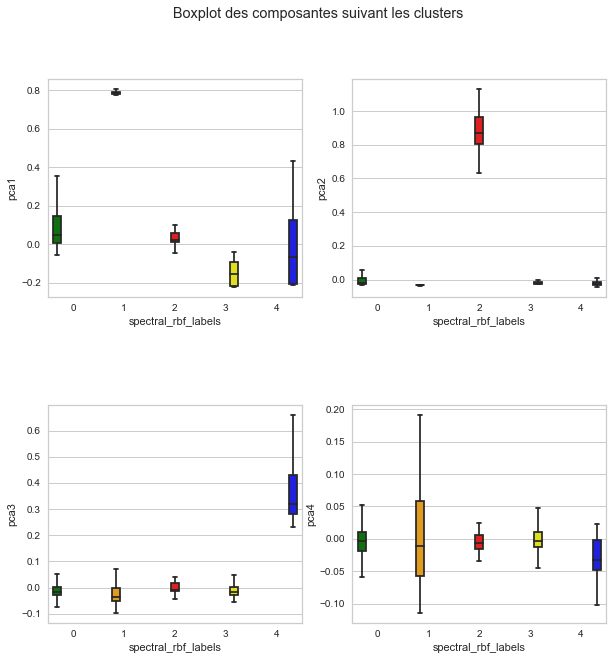

In [40]:
fig = plt.figure(figsize = (10, 10))
plt.gcf().subplots_adjust(hspace = 0.5, wspace = 0.2)
plt.suptitle('Boxplot des composantes suivant les clusters')

for k in range(4) :
    ax = fig.add_subplot(2, 2, 1 + k )
    ax=sns.boxplot(data=df_pca,x='spectral_rbf_labels',y='pca'+str(k+1),hue='spectral_rbf_labels',
                palette={0:'green',1:'orange',2:'red',3:'yellow',4:'blue'},showfliers=False)
    plt.gca().legend().set_visible(False)
plt.show()

In [41]:
# repartition des vendeurs par cluster
df_pca['spectral_rbf_labels'].value_counts().sort_values()

2      14
4      39
1      78
3    1350
0    1489
Name: spectral_rbf_labels, dtype: int64

On a des clusters non equilibres, mais peut-etre significatifs

In [42]:
dfv['clusters'] = df_pca['spectral_rbf_labels'].values

In [43]:
mean_per_cluster=dfv.groupby('clusters').mean()
mean_per_cluster

,nb_customers,turnover,mean_delivery_nb_days,mean_review_score,mean_freight,baby_toys,books_dvd_media_stationery,fashion_clothes_accessories,furnitures,gifts_flowers,health_beauty,home,others,sports_leisures,technology,tools_garden
clusters,,,,,,,,,,,,,,,,
0,42.589657,5522.284433,13.098232,3.759346,25.317233,0.068130,0.028095,0.030758,0.150607,0.040547,0.114450,0.111767,0.178608,0.095494,0.114855,0.066688
1,1.346154,607.144359,26.010150,1.069231,27.616752,0.087607,0.012821,0.012821,0.128205,0.079060,0.087607,0.097756,0.218483,0.096154,0.076923,0.102564
2,1105.142857,155475.492857,13.181509,4.038687,23.738620,0.025414,0.054418,0.012123,0.278927,0.335072,0.090574,0.024366,0.011819,0.010545,0.076004,0.080738
3,13.118519,1920.256719,10.119167,4.730139,23.752135,0.071680,0.060999,0.037585,0.088044,0.037618,0.148562,0.113160,0.200792,0.106098,0.065284,0.070179
4,4.948718,4678.355385,15.657785,4.099506,169.232915,0.041026,0.000000,0.000000,0.266267,0.025641,0.051282,0.085470,0.200866,0.117483,0.087179,0.124786


Les conclusions de ces clusters sont les suivantes :
- clusteur 0 : vendeurs ayant des avis assez faibles donc il faut regarder les clients de ces vendeurs pour pouvoir les conseiller
- cluster 1 : vendeurs ayant tres peu de clients, un delais de livraison le plus long, tres mal note => proposer une formation sur le e-commerce
- cluster 2 : vendeurs ayant le plus de clients, un delais de livraison correct et le prix de fret le plus faible => objectif augmenter leur CA
- cluster 3 : vendeurs ayant le plus rapide delais de livraison, bien note, faible prix de fret => doivent etre conseilles pour augmenter leur nombre de clients
- cluster 4 : vendeurs ayant un faible nombre de clients mais surtout un prix de fret exhorbitant => augmenter le nombre de clients et voir ce qui peut etre fait pour le fret

In [44]:
# regroupement des vendeurs par cluster
dfv.reset_index(inplace=True)
dfv.drop(list_cat,axis=1,inplace=True)
cluster_0 = dfv[dfv['clusters']==0].copy()
cluster_1 = dfv[dfv['clusters']==1].copy()
cluster_2 = dfv[dfv['clusters']==2].copy()
cluster_3 = dfv[dfv['clusters']==3].copy()
cluster_4 = dfv[dfv['clusters']==4].copy()

On relie les clients aux vendeurs

In [45]:
client_seller = pd.read_csv("C:/Users/leila/client_seller.csv")
dfc = pd.read_csv("C:/Users/leila/customers_labels.csv")

In [47]:
# test sur un cluster de vendeurs
seller_cluster1 = pd.merge(cluster_1,client_seller,how='left',on='seller_id')

seller_cluster1 = pd.merge(seller_cluster1, dfc[['customer_unique_id','cluster_client']],
                           how = 'left', on = 'customer_unique_id')

# types de clients 
seller_cluster1['cluster_client'].value_counts().sort_values()

4     1
3     1
0     3
2     4
1    96
Name: cluster_client, dtype: int64

In [49]:
temp = pd.merge(dfv, client_seller, how = 'left', on = 'seller_id')
temp = pd.merge(temp, dfc[['customer_unique_id','cluster_client']],
                                   how = 'left', on = 'customer_unique_id')
sellers_customers_labels = temp[['clusters','cluster_client']]


In [52]:
table = sellers_customers_labels.pivot_table(index = 'clusters',  columns = 'cluster_client',
                                             aggfunc = {'cluster_client': 'count'})
table

cluster_client                           
cluster_client              0     1      2      3      4
clusters                                                
0                       13874  9848  14071  15370  10253
1                           3    96      4      1      1
2                        2944  2217   4416   3614   2281
3                        6300   954   3729   3878   2849
4                          62    25     39     20     47

Olist peut donc proposer aux vendeurs (clients d'olist) une segmentation de leurs clients. 
- cluster_client 0 : clients satisfaits qui ont recu leurs commandes rapidement apres avoir passer leurs achats generalement en juin et qui sont les plus recents
- cluster_client 1 : clients tres insatisfaits, en particulier pour un delais de livraison trop long et qui n'ont plus commande depuis 8 mois
- cluster_client 2 : clients qui commandent vers la fin de l'annee et en moyenne n'ont plus commande depuis 10 mois alors qu'ils etaient satisfaits
- cluster_client 3 : clients satisfaits, commandant en debut d'annee qui n'ont plus commande depuis 6 mois
- clusteur_client 4 : clients satisfaits qui ont recu leur commande dans un delais satisfaisant, qui commandent en moyenne en avril mais qui n'ont pas commande depuis longtemps (16 mois)

Regardons le cluster 0 des vendeurs

In [54]:
seller_cluster0 = temp[temp['clusters']==0]
vendeurs = list(seller_cluster0[seller_cluster0['cluster_client']==1]['seller_id'].unique())
len(vendeurs)

1244

Dans le cluster 0 des vendeurs 1244 vendeurs sont concernes par des avis negatifs des clients, sachant qu'ils ont en moyenne 42 clients, il faudra regarder ce qui s'est passe avec les commentaires clients. Afin d'augmenter leur nombre de commandes, comme les clients sont récents leur suggerer de relancer leurs clients du cluster 0 par une offre promotionnelle ou autre. Pour leurs clients du cluster 2 peut être leur proposer de les solliciter en leur proposant un genre de carte de fidelite pour les inciter a revenir. >Ils devraient sans doute aussi proposer unepromotion ou autre demarche pour se rappeler au bon souvenir des clients du cluster 3. 

L'equipe marketing peut ainsi se repartir les vendeurs par clusters et leurs proposer une segmentation de leurs clients et une formation pour les vendeurs du cluster 2